## Environment setup
These are 2 utility functions to configure environment variables
depending on whether we run the code on local jupyter notebook
or on Google Colab.


In [1]:
def get_enum(a, only_one=None):
    if only_one is None:
        only_one = False

    x = None
    res = []
    allowed_names = [
        o.name for o in a
    ]
    while len(res) == 0:
        print(
            'Enter some of the values: %s' % ', '.join(allowed_names)
        )
        input_text = input().strip().upper()
    
        if input_text == '__ALL__':
            res = list(a)
        elif input_text == '__NONE__':
            res = []
        else:
            entries = input_text.split()
    
            for o in entries:
                if o in allowed_names:
                    res.append(a[o])

        if only_one and len(res) != 1:
            res = []

    if only_one:
        return res[0]
    else:
        return res

In [7]:
import enum
import os
os.environ['PROJECT_NAME'] = 'case_study'

class CLOUD_T(enum.Enum):
    GOOGLE_COLAB_GPU = 0
    GOOGLE_COLAB_TPU = 2
    LOCAL_MACHINE = 3

CLOUD_TYPE = get_enum(CLOUD_T, only_one=True)

if CLOUD_TYPE in [
    CLOUD_T.GOOGLE_COLAB_GPU,
    CLOUD_T.GOOGLE_COLAB_TPU,
]:
    from google.colab import drive
    drive.mount('/content/drive')    

    os.environ['PROJECT_ROOT'] = os.path.join(
        '/content/Documents/current',
        os.environ['PROJECT_NAME'],
    )    

    os.environ['CACHE_DIR'] = os.path.join(
        '/content/drive/My Drive/Documents/current',
        os.environ['PROJECT_NAME'],
        'tmp',
        'cache'
    )
elif CLOUD_TYPE is CLOUD_T.LOCAL_MACHINE:
    os.environ['PROJECT_ROOT'] = os.path.join(
        os.path.abspath(os.path.curdir),
        '..', '..'
    )

    os.environ['CACHE_DIR'] = os.path.join(
        os.environ['PROJECT_ROOT'],
        'tmp',
        'cache'
    )
else:
    raise NotImplemented
    
os.environ['VOLATILE_CACHE_DIR'] = os.path.join(
    os.environ['PROJECT_ROOT'],
    'tmp',
    'cache'
)


if CLOUD_TYPE in [
    CLOUD_T.GOOGLE_COLAB_GPU,
    CLOUD_T.GOOGLE_COLAB_TPU
]:
    os.environ['REPO_PATH'] = os.path.join(
        os.environ['CACHE_DIR'],
        'repo.tar'
    )
elif CLOUD_TYPE is CLOUD_T.LOCAL_MACHINE:
    os.environ['REPO_PATH'] = os.path.join(
        os.environ['VOLATILE_CACHE_DIR'],
        'repo.tar'
    )
else:
    raise NotImplemented

if CLOUD_TYPE is CLOUD_T.GOOGLE_COLAB_TPU:    
    assert 'COLAB_TPU_ADDR' in os.environ

os.environ['JUPYTER'] = '1'
os.environ['CLOUD_TYPE'] = CLOUD_TYPE.name


PROJECT_ROOT = os.environ['PROJECT_ROOT']
CACHE_DIR = os.environ['CACHE_DIR']
VOLATILE_CACHE_DIR = os.environ['VOLATILE_CACHE_DIR']

import sys
sys.path.append(os.environ['PROJECT_ROOT'])

Enter some of the values: GOOGLE_COLAB_GPU, GOOGLE_COLAB_TPU, LOCAL_MACHINE
LOCAL_MACHINE


In [23]:
import python.tasks
import pandas

# 1. Minimum solution: What is the best voucher overall?

Each voucher results in some mean amount of orders and mean margin.
Let's parse vouchers and obtain $Z_{mov}$ -- Minimum Order Value.
Then let's plot statistics regarding application of each voucher including
$ControlGroup$, which represents A/B testing, i.e. market operation
without intervention.

Considering the 2 plots below. We conlude the following:
1. All of the vouchers positively increase amount of orders.
And in general we have 9, 10 and 13 MOV which
with an increasing MOV for the voucher increases amount of orders we get.
The same true for another range - 18, 20 and 25.
But there's a rapid drop from 13 to 18,
and 25 to 27. That means that customers or vouchers
are different and better suited for its particular cluter of MOV.
2. As of margin, it is different. Only 3 vouchers do increase
margin substantially better than our baseline - Control Group.
If we consider both orders and margin plots.
It seems that getting an optimal MOV value results in
an increase of orders and at the same time slight drop
in margin. So its a tradeoff, either we incline for
more amount of orders, but we risk to get lots of
unwise customers, who increase our traffic, yet they are
not bringing considerable profit.
Or we go a bit far from optimal MOV within its voucher/customers
group, and amount of orders decrease - customers
are less interested in spontaneous acquisitions,
but on the other hand we had qualitatively better customers,
within this segment, they are actually spending more.

3. Overall in our opinion the best voucher is the one with MOV of 27.
It gives the best profit with a smallest amount of discount.
It is called "lv-3|3|27".

In [ ]:
z = python.tasks.kernel_4_process()

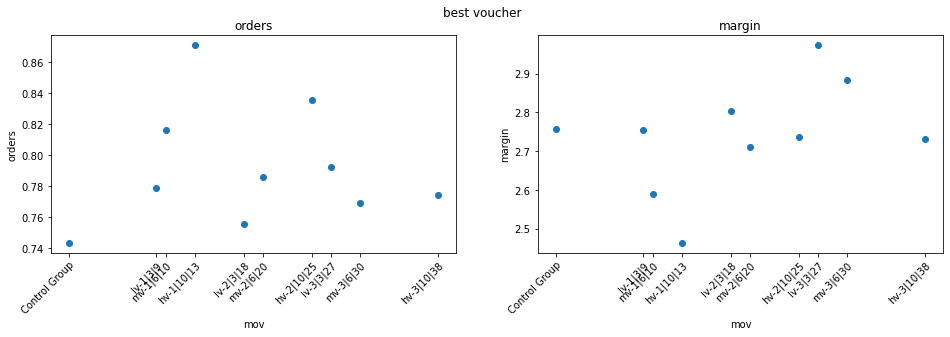

In [19]:
python.tasks.kernel_7_visual(z)

## 2. Expected Solution: What is the best single dimensions segmentation to be used?

To answer this question let's estimate properties
of market segmentation according to a single dimension,
in particular to customers having a certain value
for a particular dimension.
For that we estimate unique values for each of the dimensions,
and then obtain a cut of market according to the segmentation rule.
$$I_1 = Z_{Property_i} = UniqueValue_{ij}$$
$$I_2 = Z_{Mov} = MOV_{best voucher}$$
Then we estimate 5 properties:
* recall - $Sum(I_1 * I_2) / Sum(I_2)$

* precision - $Sum(I_1 * I_2) / Sum(I_1)$

* dimension_recall - $Mean(I_1)$
* mean margin - $Mean(Z_{Margin}[I_1])$
* mean orders - $Orders(Z_{Orders}[I_1])$


Explanation:
- So in short *recall* is amount of customers belonging to intersection
of indicators $I_1$ and $I_2$ divided by overall amount of customers
in the group $I_2$. I.e. how much of vouchers customers are segmented
with this rule.

- *precision* is amount of customers belonging to $I_1$ and $I_2$
devided by amount of customers in the group $I_1$,
i.e. what portion of voucher subgroup is being segmented
regarding the over all segmentation size.

- *domain_recall* is the segmentation size, just amount of customers
we get by using this rule.

- *mean margin* is mean margin within group $I_1$.
- *mean orders* is mean orders within group $I_2$.

We provide *mean margin* and *mean orders* estimates for all of the customers,
per property value pair, then separately for control group customers only,
and voucher presented customers only.
Overall we get 2 tables with properties, and 2 figures with 2 and 4 plots each.
To pickup the best single dimension segmentation to be used we
must pickup a target metric we optimize *margin* or *orders*,
then pickup customers segment rule, and then decide on a voucher that has given
the best performance within this group.
It can be done by using plots to overall overview first,
and then considering the second of 2 provided tables.

Just a plot of voucher subgroups according to some 2 dimensional
representation.

/usr/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


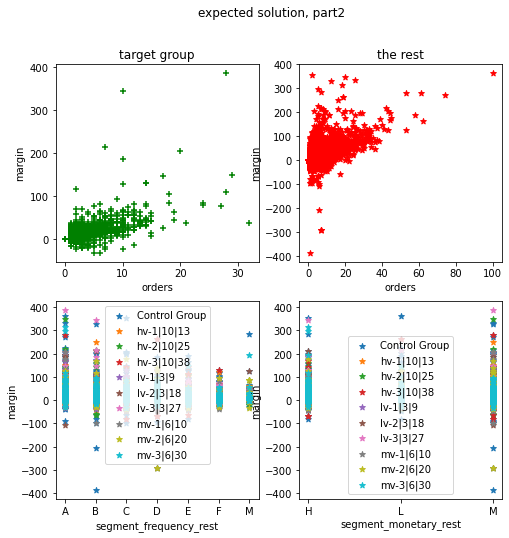

In [12]:
python.tasks.kernel_2_visual(z)

Vouchers visualization according to orders vs margin pair.
Each plot represents a separate MOV, as a result we 
get different vouchers. Name of the voucher is given in the legend.

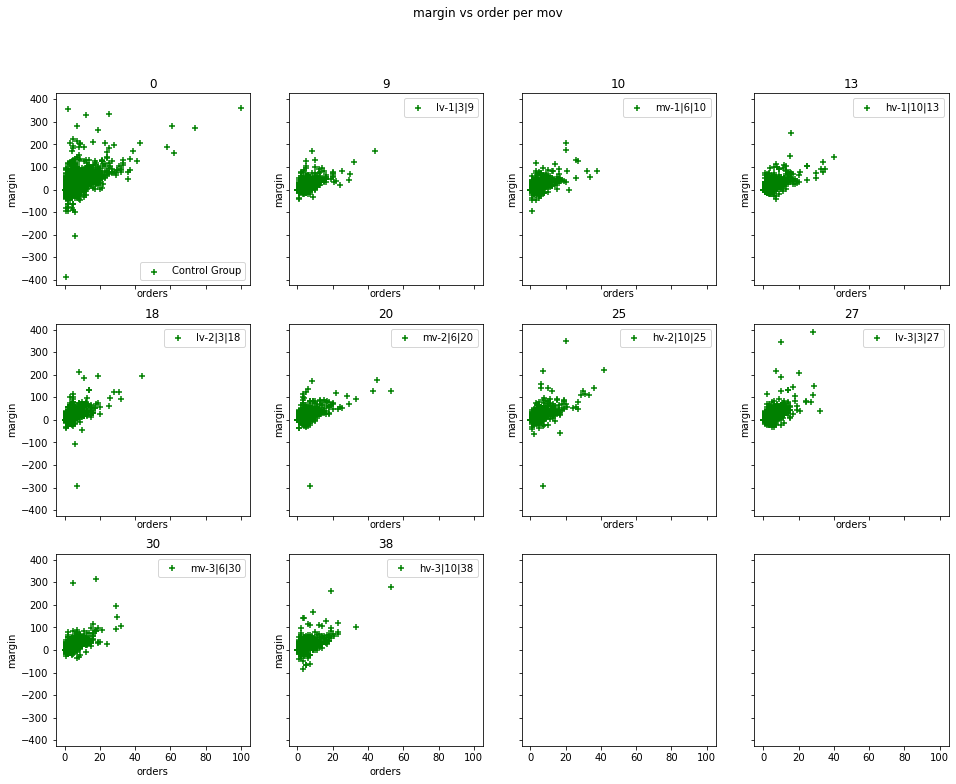

In [38]:
python.tasks.kernel_6_visual(z)

In [56]:
o_3 = python.tasks.kernel_3_visual(z)

Table of one dimensional segmentation rule properties,
customers, no A/B separation.

In [57]:
o_3['z16']

,k,recall,precision,dimension_recall,mean_margin,mean_orders
H,segment_monetary_rest,0.214986,0.057532,0.215030,3.203295,0.610316
L,segment_monetary_rest,0.357749,0.056573,0.363888,2.191106,0.787593
M,segment_monetary_rest,0.427265,0.058389,0.421082,2.996233,0.839013
H,segment_discount_dh_rest,0.027221,0.063611,0.024624,0.789381,0.464261
M,segment_discount_dh_rest,0.016757,0.061002,0.015807,5.333767,1.507459
N,segment_discount_dh_rest,0.956022,0.057331,0.959568,2.755439,0.766870
H,segment_variety_rest,0.129006,0.059370,0.125038,6.476056,1.703721
L,segment_variety_rest,0.073174,0.055528,0.075831,4.024482,1.130546
M,segment_variety_rest,0.295844,0.058966,0.288709,3.143816,0.872296
N,segment_variety_rest,0.501976,0.056592,0.510422,1.420784,0.432044


Visualization of the table above, for dimension_recall(market_recall) and either mean group margin, or mean
group orders pairs.

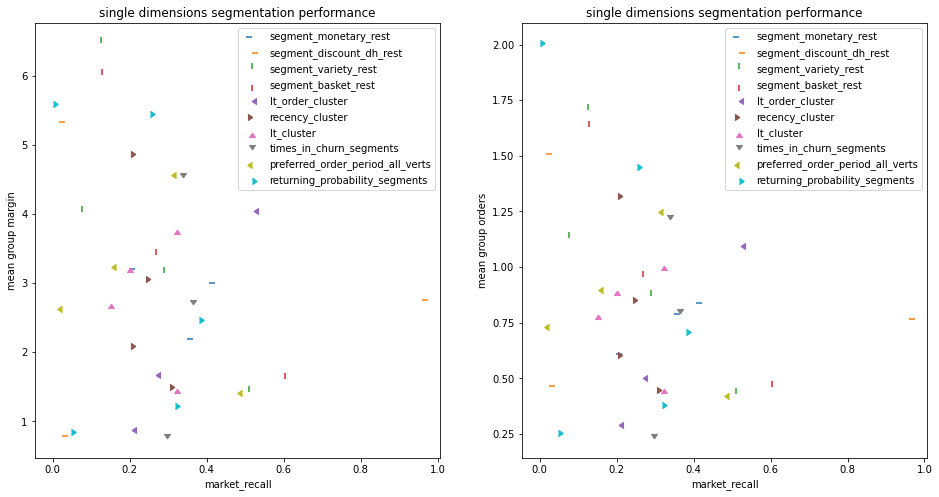

In [58]:
python.tasks.kernel_5_plot(o_3)

Table of one dimensional segmentation rule properties, only mean_margin, mean_orders and dimension_recall
for A and B splits, i.e. Control Group and Voucher Group (customers given any voucher).

In [41]:
o_8 = python.tasks.kernel_8_preprocess(z)

In [44]:
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(
        o_8['z16']
    )

,subgroup_name,subgroup_recall,k,dimension_recall,mean_margin,mean_orders
H,Control Group,0.486665,segment_monetary_rest,0.215622,3.157186,0.579792
L,Control Group,0.486665,segment_monetary_rest,0.366993,2.186031,0.756672
M,Control Group,0.486665,segment_monetary_rest,0.417384,3.051671,0.816086
H,Control Group,0.486665,segment_discount_dh_rest,0.023724,0.679070,0.386579
M,Control Group,0.486665,segment_discount_dh_rest,0.015254,4.963318,1.414634
N,Control Group,0.486665,segment_discount_dh_rest,0.961022,2.773005,0.741483
H,Control Group,0.486665,segment_variety_rest,0.124307,6.546711,1.690332
L,Control Group,0.486665,segment_variety_rest,0.075768,4.104744,1.104374
M,Control Group,0.486665,segment_variety_rest,0.287973,3.131727,0.835622
N,Control Group,0.486665,segment_variety_rest,0.511953,1.426068,0.408045


Visualization for the table above.

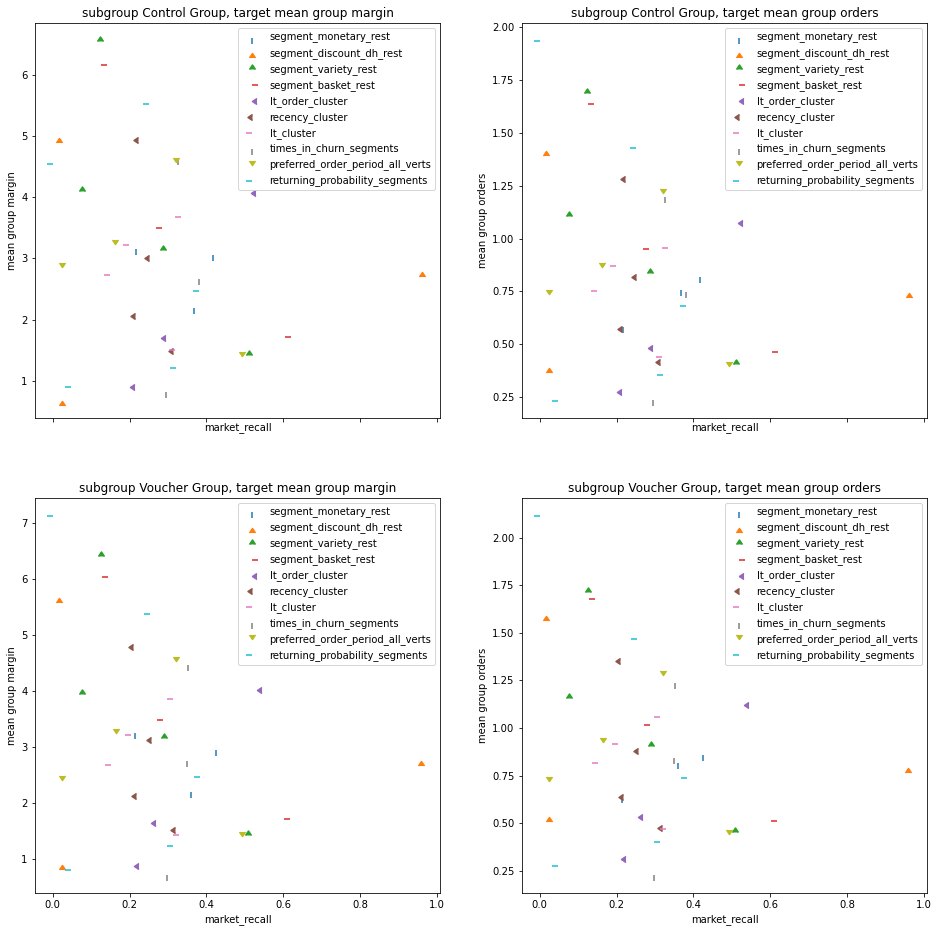

In [51]:
python.tasks.kernel_10_plot(o_8)

## 3. Best Solution: Train model to assign the optimal voucher on a customer level.

In [31]:
o_9 = python.tasks.kernel_9_preprocess(z)

In [32]:
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(o_9['z16'])

,Control Group,lv-1|3|9,mv-1|6|10,hv-1|10|13,lv-2|3|18,mv-2|6|20,hv-2|10|25,lv-3|3|27,mv-3|6|30,hv-3|10|38,k
H,0.104936,0.012123,0.012396,0.012043,0.012523,0.011756,0.011996,0.012371,0.012476,0.012409,segment_monetary_rest
L,0.178603,0.020569,0.020553,0.020443,0.020923,0.020961,0.020005,0.020586,0.020329,0.020915,segment_monetary_rest
M,0.203126,0.024031,0.024195,0.024262,0.024220,0.024212,0.023858,0.024587,0.024351,0.024241,segment_monetary_rest
H,0.011546,0.001537,0.001516,0.001381,0.001432,0.001377,0.001419,0.001566,0.001364,0.001486,segment_discount_dh_rest
M,0.007424,0.001015,0.000994,0.000888,0.000914,0.000918,0.000893,0.000964,0.000893,0.000905,segment_discount_dh_rest
N,0.467695,0.054171,0.054634,0.054479,0.055321,0.054634,0.053548,0.055013,0.054900,0.055173,segment_discount_dh_rest
H,0.060496,0.007411,0.007386,0.007112,0.007390,0.006939,0.006944,0.007424,0.006855,0.007082,segment_variety_rest
L,0.036873,0.004569,0.004253,0.004249,0.004413,0.004261,0.004316,0.004211,0.004455,0.004232,segment_variety_rest
M,0.140146,0.016287,0.016338,0.016388,0.016430,0.016531,0.016283,0.017024,0.016468,0.016813,segment_variety_rest
N,0.249149,0.028456,0.029168,0.028999,0.029433,0.029197,0.028317,0.028886,0.029378,0.029437,segment_variety_rest


It seems that in general, we are given 10 options overall.
Each customer can be assigned one of the vouchers,
or we can leave him as it is.
Considering that vouchers where assigned independently
of provided segmentation dimensions.
Then each voucher performance statistics,
just represent a marginal customers distribution.
We are to disjointly cover set of customers
with 10 voucher classes.
And the objective is to optimize either mean_orders, or mean_margin.

We are going to consider a model of decision lists.
We sample an order in which we apply all of the above one dimensional segmentation rules
one by one.
Since we are to produce a disjoint set covering.
We are eliminating all of the affected customers so far,
and segment the rest of the market.
Also, we consider for each of those rules a possibility
of it not being applied at all.
Below we sample 10 uniformly selected models with a predifinied seed=0,
and evaluate there meean_margin and mean_orders for each of TRAIN, TEST and VAL splits.
Overall we have not noticed much deviation between TRAIN and TEST splits,
perhaps due to a model simplicity.
So all of the results below are produced for TRAIN split only.
We do a kind of model verification by plotting,
mean_orders sorted increasingly, where as mean_margin is the one that model had
same goes for mean_margin, we sort model by their mean_margin performance in ascending order,
mean_orders go as they are.
Overall we have a pretty good variety on models to pick from.

In [61]:
o_13 = python.tasks.kernel_13_split(z)

In [59]:
o_11 = {}

In [62]:
python.tasks.kernel_11_model(z, o_9, o_11, o_13, 10) 

In [63]:
o_12 = python.tasks.kernel_12_evaluate(z, o_11, o_13)

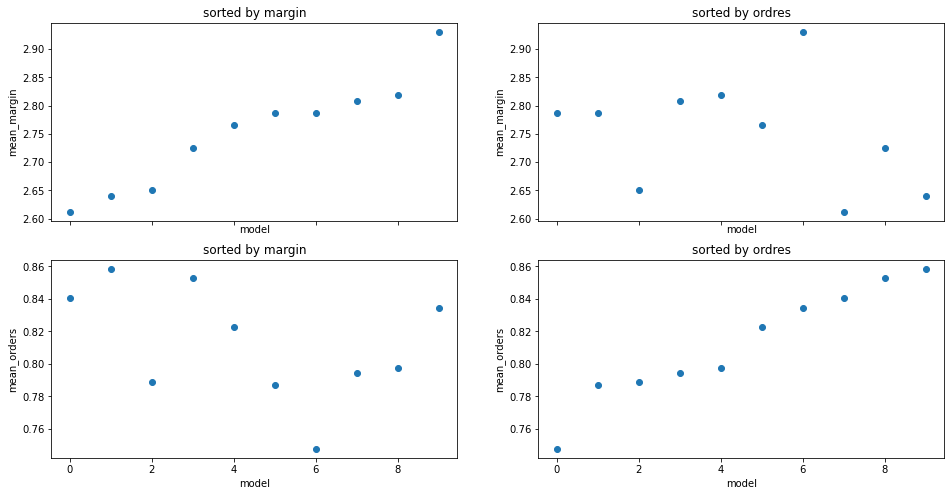

In [64]:
python.tasks.kernel_14_cross_validation(z, o_12)